**Deep Learning-based Pneumonia Detection Using Chest X-Ray Images**

Programming Assignment #1

CAP 5516 - Medical Image Computing (Spring 2026)



*Darinka Townsend*

**Libraries**

In [30]:
!pip install tqdm

In [75]:
import os
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
from PIL import Image
from tqdm import tqdm
import kagglehub

# Modules
import utils
import model
import train_utils

import importlib
importlib.reload(utils)
importlib.reload(model)
importlib.reload(train_utils)


<module 'train_utils' from '/content/train_utils.py'>

**DataSet**

In [13]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Path to dataset files:", path)
DATA_DIR = os.path.join(path, "chest_xray")
print(os.listdir(DATA_DIR))

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia
['chest_xray', '__MACOSX', 'val', 'test', 'train']


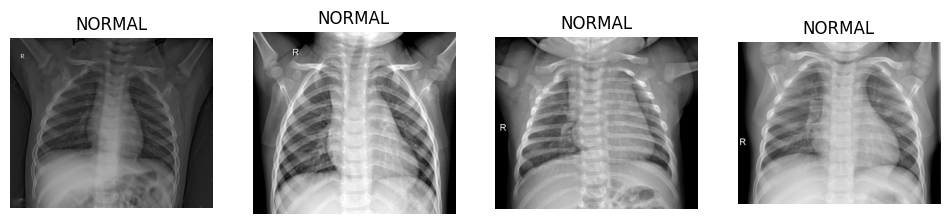

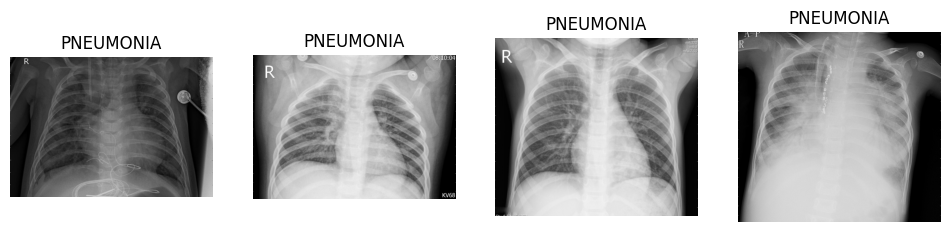

In [16]:
train_folder = os.path.join(DATA_DIR, "train")
utils.show_images(train_folder, "NORMAL", n=4)
utils.show_images(train_folder, "PNEUMONIA", n=4)

In [17]:
print("Train images:", utils.count_images(os.path.join(DATA_DIR, "train")))
print("Val images:", utils.count_images(os.path.join(DATA_DIR, "val")))
print("Test images:", utils.count_images(os.path.join(DATA_DIR, "test")))

Train images: 5216
Val images: 16
Test images: 624


In [18]:
train_dir = os.path.join(DATA_DIR, "train")
val_dir   = os.path.join(DATA_DIR, "val")
test_dir  = os.path.join(DATA_DIR, "test")

train_counts = utils.class_counts(train_dir)
val_counts   = utils.class_counts(val_dir)
test_counts  = utils.class_counts(test_dir)

print("TRAIN:", train_counts)
print("VAL:  ", val_counts)
print("TEST: ", test_counts)

TRAIN: {'NORMAL': 1341, 'PNEUMONIA': 3875}
VAL:   {'NORMAL': 8, 'PNEUMONIA': 8}
TEST:  {'NORMAL': 234, 'PNEUMONIA': 390}


In [6]:
utils.print_percentages(train_counts, "TRAIN")
utils.print_percentages(val_counts,   "VAL")
utils.print_percentages(test_counts,  "TEST")


TRAIN total = 5216
  NORMAL    :  1341  (25.71%)
  PNEUMONIA :  3875  (74.29%)

VAL total = 16
  NORMAL    :     8  (50.00%)
  PNEUMONIA :     8  (50.00%)

TEST total = 624
  NORMAL    :   234  (37.50%)
  PNEUMONIA :   390  (62.50%)


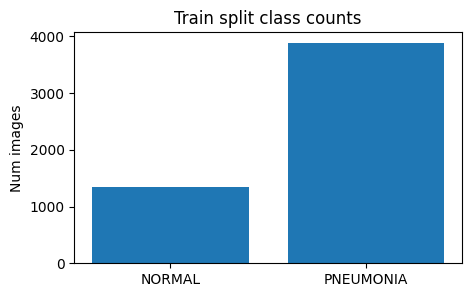

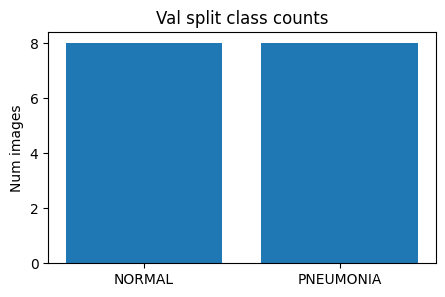

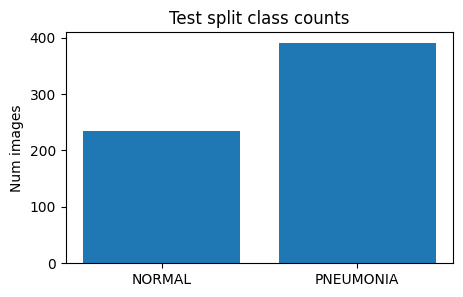

In [19]:
utils.barplot_counts(train_counts, "Train split class counts")
utils.barplot_counts(val_counts,   "Val split class counts")
utils.barplot_counts(test_counts,  "Test split class counts")

# **Data Augmentation**

*Train DataSet*

In [22]:
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(
    os.path.join(DATA_DIR, "train"),
    transform=train_transforms
)

print("Train dataset size:", len(train_dataset))
print("Classes:", train_dataset.classes)



Train dataset size: 5216
Classes: ['NORMAL', 'PNEUMONIA']


# **Class Weight**

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = utils.compute_class_weights(train_dataset, device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

Class distribution:
NORMAL: count=1341, weight=1.9448
PNEUMONIA: count=3875, weight=0.6730


# **DataLoaders**

In [34]:
eval_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_dataset = datasets.ImageFolder(
    os.path.join(DATA_DIR, "val"),
    transform=eval_transforms
)

test_dataset = datasets.ImageFolder(
    os.path.join(DATA_DIR, "test"),
    transform=eval_transforms
)

In [37]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=1,
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=1,
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=1,
    pin_memory=False
)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))
print("Test batches:", len(test_loader))

Train batches: 163
Val batches: 1
Test batches: 20


# **Task 1.1: ResNet-18**

***Inicialization***

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = model.PneumoniaResNet18(pretrained=False)
net = net.to(device)
print(net)

PneumoniaResNet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

***Loss***

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = utils.compute_class_weights(train_dataset, device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

Class distribution:
NORMAL: count=1341, weight=1.9448
PNEUMONIA: count=3875, weight=0.6730


***Optimizer***

In [28]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)

In [29]:
print("Device:", device)
print("Loss weights:", class_weights)
print("LR:", optimizer.param_groups[0]["lr"])

Device: cuda
Loss weights: tensor([1.9448, 0.6730], device='cuda:0')
LR: 0.0001


***Training***

In [38]:
history = train_utils.train_model(
    model=net,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=10,
    scheduler=None,
    save_path="best_resnet18_scratch.pt",
    print_every=50
)

  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 1/10 | LR 1.00e-04 | train_loss 0.1432 acc 0.9448 | val_loss 2.4702 acc 0.5625
Saved best model to best_resnet18_scratch.pt (val_loss=2.4702)


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 2/10 | LR 1.00e-04 | train_loss 0.1342 acc 0.9521 | val_loss 3.0905 acc 0.5625


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 3/10 | LR 1.00e-04 | train_loss 0.1289 acc 0.9526 | val_loss 0.7141 acc 0.9375
Saved best model to best_resnet18_scratch.pt (val_loss=0.7141)


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 4/10 | LR 1.00e-04 | train_loss 0.1086 acc 0.9594 | val_loss 0.4713 acc 0.8750
Saved best model to best_resnet18_scratch.pt (val_loss=0.4713)


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 5/10 | LR 1.00e-04 | train_loss 0.1129 acc 0.9586 | val_loss 3.1392 acc 0.5625


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 6/10 | LR 1.00e-04 | train_loss 0.1006 acc 0.9657 | val_loss 2.2823 acc 0.5625


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 7/10 | LR 1.00e-04 | train_loss 0.0968 acc 0.9643 | val_loss 2.3527 acc 0.5625


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 8/10 | LR 1.00e-04 | train_loss 0.1122 acc 0.9588 | val_loss 2.3901 acc 0.5625


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 9/10 | LR 1.00e-04 | train_loss 0.0951 acc 0.9672 | val_loss 1.9160 acc 0.6250


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 10/10 | LR 1.00e-04 | train_loss 0.0903 acc 0.9651 | val_loss 3.5318 acc 0.5625


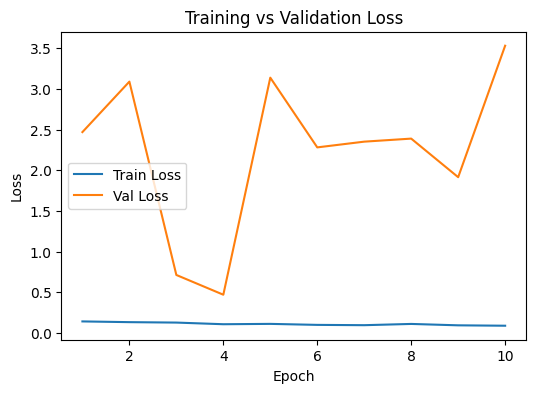

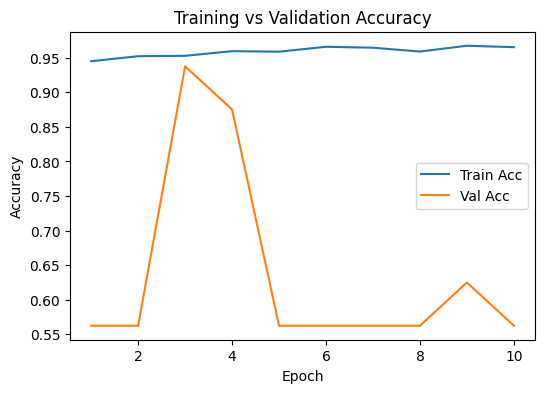

In [42]:
train_utils.plot_history(history)

***Evaluation in Test***

In [43]:
net.load_state_dict(torch.load("best_resnet18_scratch.pt", map_location=device))
net.to(device)
net.eval()

PneumoniaResNet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [45]:
test_acc, per_class_acc, cm, preds, labels = train_utils.evaluate_test(
    net,
    test_loader,
    device,
    test_dataset.classes
)

print(f"Test Accuracy (overall): {test_acc:.4f}")
print("Test Accuracy (per class):")
for k, v in per_class_acc.items():
    print(f"  {k}: {v:.4f}")

Test Accuracy (overall): 0.7372
Test Accuracy (per class):
  NORMAL: 0.3462
  PNEUMONIA: 0.9718


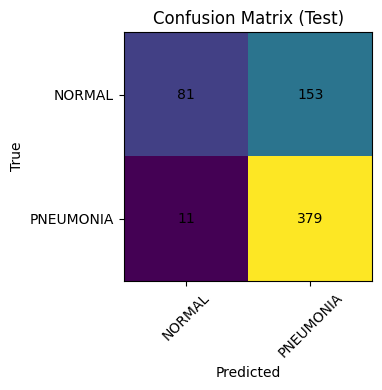

In [46]:
train_utils.plot_confusion_matrix(cm, test_dataset.classes)

In [48]:
metrics = train_utils.compute_classification_metrics(cm, test_dataset.classes)


Class-wise Metrics:
NORMAL:
  Precision: 0.8804
  Recall:    0.3462
  F1-score:  0.4969
PNEUMONIA:
  Precision: 0.7124
  Recall:    0.9718
  F1-score:  0.8221

Macro Average:
  Precision: 0.7964
  Recall:    0.6590
  F1-score:  0.6595


Although the overall test accuracy reached 73.7%, class-wise analysis reveals a strong bias toward the majority class (Pneumonia). The model achieves very high recall for Pneumonia (97.2%), but performs poorly in detecting Normal cases (recall 34.6%). This indicates that training from scratch on an imbalanced dataset leads to a classifier that over-predicts the dominant class.

# **Task 1.2: ResNet-18 Transfer Learning**

***Inicialization***

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net_ft = model.PneumoniaResNet18(pretrained=True)
net_ft = net_ft.to(device)
print(net_ft)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s]

PneumoniaResNet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

***Loss***

In [50]:
class_weights = utils.compute_class_weights(train_dataset, device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

Class distribution:
NORMAL: count=1341, weight=1.9448
PNEUMONIA: count=3875, weight=0.6730


***Optimizer***

In [51]:
lr_ft = 1e-5
optimizer = torch.optim.Adam(net_ft.parameters(), lr=lr_ft, weight_decay=1e-4)

***Training***

In [52]:
history_ft = train_utils.train_model(
    model=net_ft,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=10,
    scheduler=None,
    save_path="best_resnet18_pretrained.pt",
    print_every=50
)

  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 1/10 | LR 1.00e-05 | train_loss 0.3841 acc 0.7512 | val_loss 0.7726 acc 0.6875
Saved best model to best_resnet18_pretrained.pt (val_loss=0.7726)


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 2/10 | LR 1.00e-05 | train_loss 0.1405 acc 0.9534 | val_loss 1.1563 acc 0.6875


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 3/10 | LR 1.00e-05 | train_loss 0.1147 acc 0.9615 | val_loss 1.3227 acc 0.6250


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 4/10 | LR 1.00e-05 | train_loss 0.0961 acc 0.9688 | val_loss 1.0248 acc 0.6875


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 5/10 | LR 1.00e-05 | train_loss 0.0814 acc 0.9734 | val_loss 1.2004 acc 0.6250


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 6/10 | LR 1.00e-05 | train_loss 0.0805 acc 0.9753 | val_loss 0.9330 acc 0.6875


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 7/10 | LR 1.00e-05 | train_loss 0.0834 acc 0.9734 | val_loss 0.7074 acc 0.7500
Saved best model to best_resnet18_pretrained.pt (val_loss=0.7074)


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 8/10 | LR 1.00e-05 | train_loss 0.0668 acc 0.9793 | val_loss 1.4015 acc 0.5625


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 9/10 | LR 1.00e-05 | train_loss 0.0641 acc 0.9789 | val_loss 1.0524 acc 0.6875


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 10/10 | LR 1.00e-05 | train_loss 0.0554 acc 0.9818 | val_loss 0.7093 acc 0.7500


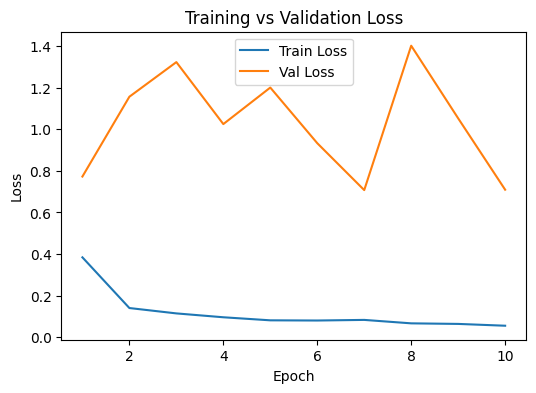

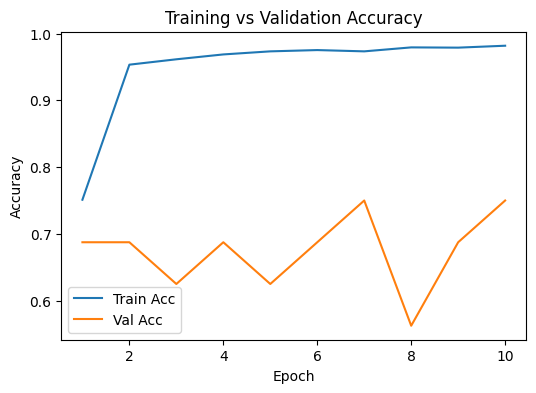

In [54]:
train_utils.plot_history(history_ft)

***Evaluation in Test***

In [53]:
net_ft.load_state_dict(torch.load("best_resnet18_pretrained.pt", map_location=device))
net_ft.to(device)
net_ft.eval()

test_acc2, per_class_acc2, cm2, preds2, labels2 = train_utils.evaluate_test(
    net_ft, test_loader, device, test_dataset.classes
)

print(f"Task 1.2 Test Accuracy (overall): {test_acc2:.4f}")
print("Task 1.2 Test Accuracy (per class):")
for k, v in per_class_acc2.items():
    print(f"  {k}: {v:.4f}")

Task 1.2 Test Accuracy (overall): 0.7965
Task 1.2 Test Accuracy (per class):
  NORMAL: 0.4615
  PNEUMONIA: 0.9974


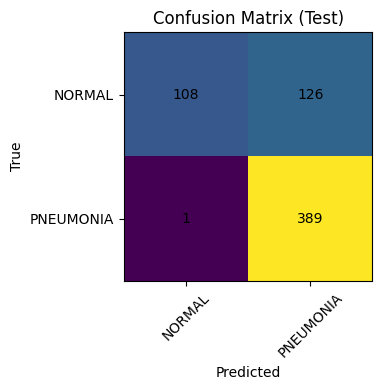

In [55]:
train_utils.plot_confusion_matrix(cm2, test_dataset.classes)

In [56]:
metrics2 = train_utils.compute_classification_metrics(cm2, test_dataset.classes)


Class-wise Metrics:
NORMAL:
  Precision: 0.9908
  Recall:    0.4615
  F1-score:  0.6297
PNEUMONIA:
  Precision: 0.7553
  Recall:    0.9974
  F1-score:  0.8597

Macro Average:
  Precision: 0.8731
  Recall:    0.7295
  F1-score:  0.7447


The transfer learning approach significantly improved the overall performance compared to training from scratch. The test accuracy increased from 73.7% to 79.6%, and the macro F1-score improved notably. The model achieved near-perfect recall for the Pneumonia class (99.7%), indicating excellent sensitivity in detecting positive cases. However, the recall for the Normal class remains relatively low (46.1%), meaning the model still tends to over-predict Pneumonia and generate false positives. Although pretraining improved feature extraction and generalization, class imbalance continues to influence the decision boundary, suggesting that additional balancing strategies are necessary.

# **Improve with WeightedRandomSampler**

***DataLoader with WeightedRandomSampler***

In [63]:
labels = [y for _, y in train_dataset]
class_counts = Counter(labels)

num_classes = len(train_dataset.classes)
class_sample_count = torch.tensor(
    [class_counts[i] for i in range(num_classes)],
    dtype=torch.float
)

weights = 1.0 / class_sample_count

sample_weights = torch.tensor([weights[y] for y in labels], dtype=torch.float)

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    sampler=sampler,
    num_workers=0,
    pin_memory=True,
    persistent_workers=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    persistent_workers=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    persistent_workers=False
)

***Inicialization***

In [64]:
net_ft = model.PneumoniaResNet18(pretrained=True).to(device)

***Optimizer***

In [65]:
optimizer = torch.optim.Adam(net_ft.parameters(), lr=1e-5, weight_decay=1e-4)

***Loss***

In [66]:
criterion = torch.nn.CrossEntropyLoss()

***Training***

In [67]:
history_ft_balanced = train_utils.train_model(
    model=net_ft,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=10,
    scheduler=None,
    save_path="best_resnet18_pretrained_balanced.pt"
)

  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 1/10 | LR 1.00e-05 | train_loss 0.2305 acc 0.9197 | val_loss 0.7333 acc 0.6875
Saved best model to best_resnet18_pretrained_balanced.pt (val_loss=0.7333)


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 2/10 | LR 1.00e-05 | train_loss 0.1198 acc 0.9580 | val_loss 0.4949 acc 0.7500
Saved best model to best_resnet18_pretrained_balanced.pt (val_loss=0.4949)


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 3/10 | LR 1.00e-05 | train_loss 0.0886 acc 0.9705 | val_loss 0.6070 acc 0.7500


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 4/10 | LR 1.00e-05 | train_loss 0.0781 acc 0.9711 | val_loss 0.7590 acc 0.6875


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 5/10 | LR 1.00e-05 | train_loss 0.0686 acc 0.9755 | val_loss 0.5913 acc 0.7500


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 6/10 | LR 1.00e-05 | train_loss 0.0608 acc 0.9787 | val_loss 0.7167 acc 0.6875


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 7/10 | LR 1.00e-05 | train_loss 0.0456 acc 0.9860 | val_loss 0.7272 acc 0.6875


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 8/10 | LR 1.00e-05 | train_loss 0.0494 acc 0.9845 | val_loss 0.6560 acc 0.7500


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 9/10 | LR 1.00e-05 | train_loss 0.0484 acc 0.9826 | val_loss 0.6725 acc 0.6875


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 10/10 | LR 1.00e-05 | train_loss 0.0489 acc 0.9814 | val_loss 0.7388 acc 0.6875


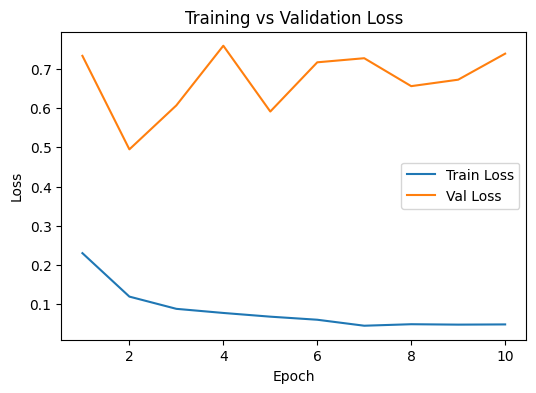

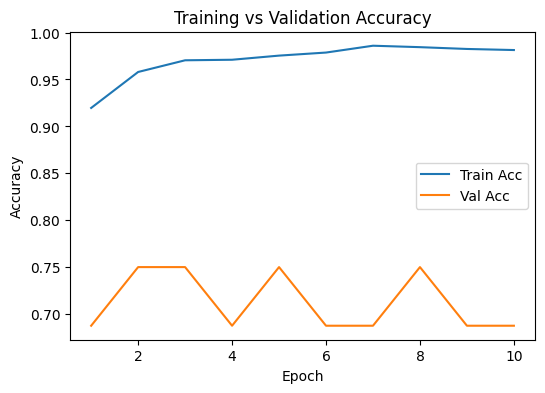

In [72]:
train_utils.plot_history(history_ft_balanced)

***Evaluation on Test***

In [68]:
net_ft.load_state_dict(torch.load("best_resnet18_pretrained_balanced.pt", map_location=device))
net_ft.eval()

test_acc_bal, per_class_acc_bal, cm_bal, _, _ = train_utils.evaluate_test(
    net_ft,
    test_loader,
    device,
    test_dataset.classes
)

In [69]:
print("Balanced Test Accuracy:", test_acc_bal)

Balanced Test Accuracy: 0.8365384340286255


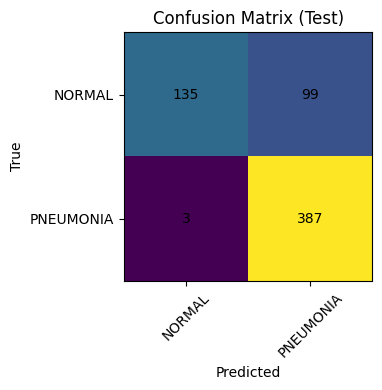

In [70]:
train_utils.plot_confusion_matrix(cm_bal, test_dataset.classes)

In [77]:
metrics3 = train_utils.compute_classification_metrics(cm_bal, test_dataset.classes)


Class-wise Metrics:
NORMAL:
  Precision: 0.9783
  Recall:    0.5769
  F1-score:  0.7258
PNEUMONIA:
  Precision: 0.7963
  Recall:    0.9923
  F1-score:  0.8836

Macro Average:
  Precision: 0.8873
  Recall:    0.7846
  F1-score:  0.8047


The balanced sampling strategy significantly reduced the bias toward the Pneumonia class by forcing the model to observe Normal samples more frequently during training. As a result, Normal recall increased from 46.1% to 57.7%, and the macro F1-score improved from 0.7447 to 0.8047, indicating a more balanced performance across classes. Importantly, Pneumonia recall remained very high (99.2%), showing that the improvement in Normal detection did not substantially harm sensitivity to Pneumonia. Overall, WeightedRandomSampler effectively mitigated class imbalance and improved generalization on the minority class.

# **Comparative Analysis**

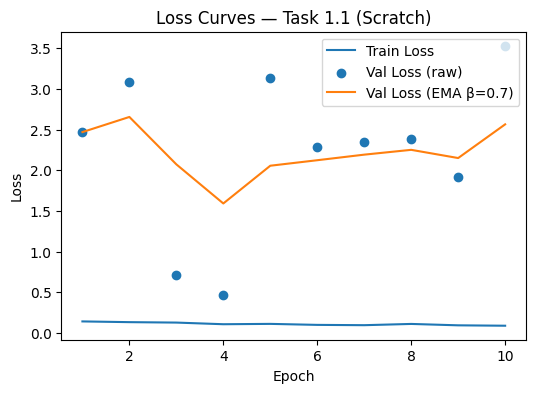

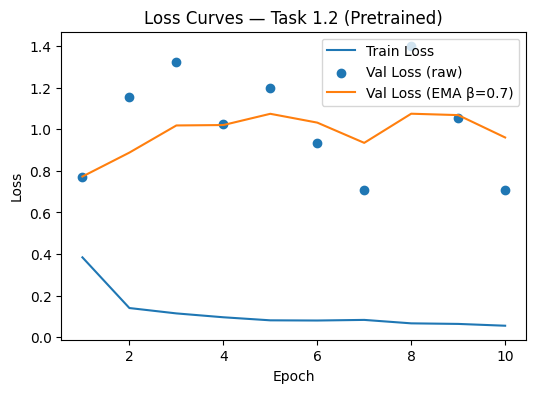

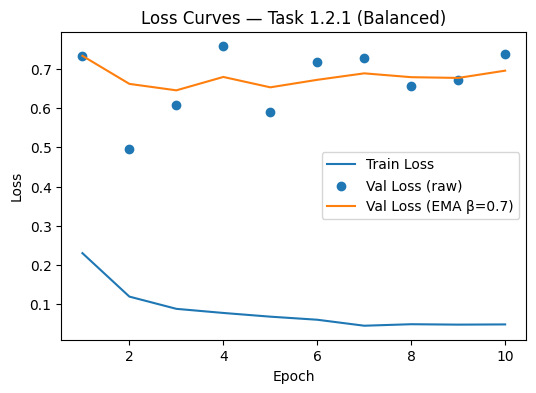

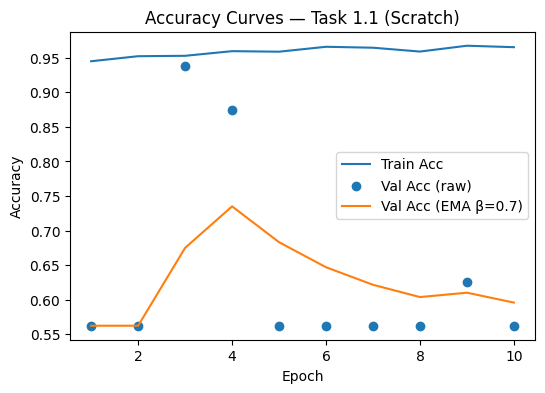

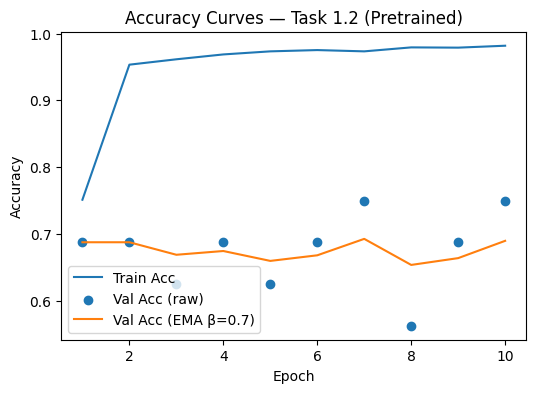

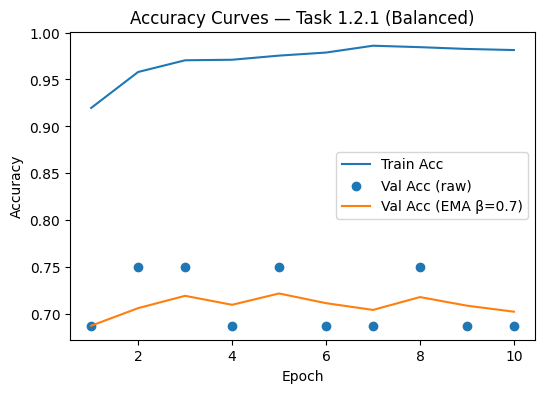

In [74]:
train_utils.plot_three_histories(
    history,
    history_ft,
    history_ft_balanced,
    ema_beta=0.7
)


===== EXPERIMENT COMPARISON =====

Model           Acc        MacroPrec    MacroRec     MacroF1   
------------------------------------------------------------
Task 1.1        0.7372     0.7964       0.6590       0.6595    
Task 1.2        0.7965     0.8731       0.7295       0.7447    
Task 1.2.1      0.8365     0.8873       0.7846       0.8047    


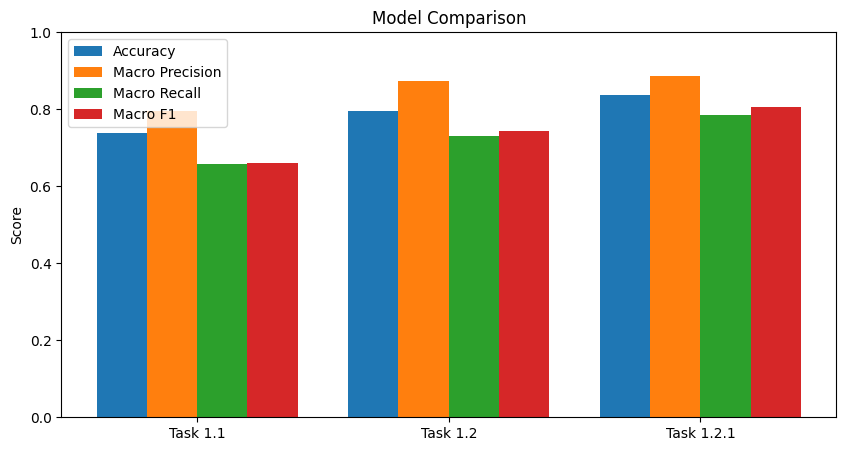

In [78]:
results = {
    "Task 1.1": {
        "accuracy": test_acc,
        "metrics": metrics
    },
    "Task 1.2": {
        "accuracy": test_acc2,
        "metrics": metrics2
    },
    "Task 1.2.1": {
        "accuracy": test_acc_bal,
        "metrics": metrics3
    }
}

train_utils.compare_experiments(results)

The experimental comparison demonstrates that transfer learning significantly improves performance over training from scratch. However, class imbalance remains a critical issue. Incorporating a balanced sampling strategy further enhances minority class detection and leads to the best overall performance. The final model (Task 1.2.1) achieves the highest accuracy and macro F1-score, indicating improved generalization and more balanced classification behavior.